In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['animation.html'] = 'html5'

import sys
import time
import math

In [68]:
def update_progress_bar(current, total):
    sys.stdout.write('\rTime step: [{:<50}] {:.0f}/{:.0f} ({:.2f}%)'.format('=' * int(current/total * 50), current, total, current*100/total))
    sys.stdout.flush()

In [87]:
ut = 1 # Top wall velocity
tf = 1 # Total time of simulation.
ν = 0.05 # Kinematic viscosity of fluid

nx = 33 # Grid points along x
ny = 33 # Grid points along y
Lx = 1.0 # Length of domain along x
Ly = 1.0 # Length of domain along y
dx = Lx/(nx - 1)
dy = Ly/(ny - 1)

print(f'Minimum required time step: {min(0.25*dx*dx/ν, (4*ν)/(ut*ut))}s')
dt = min(0.25*dx*dx/ν, (4*ν)/(ut*ut))/2
ts = math.ceil(tf/dt)
dt = tf/ts
print(f'Selected time step = {dt}s\nTotal number of time steps = {ts}')
print(f'\nStability Criteria 1 (0.25: dimensionless): {(ν*dt)/(dx*dx) < 0.25} ({(ν*dt)/(dx*dx)})')
print(f'Stability Criteria 2 (4: dimensionless): {(ut*ut*dt)/ν < 4} ({(2*ut*ut*dt)/ν})')
print(f'\nReynolds number = {ut*Lx/ν}')

Minimum required time step: 0.0048828125s
Selected time step = 0.0024390243902439024s
Total number of time steps = 410

Stability Criteria 1 (0.25: dimensionless): True (0.1248780487804878)
Stability Criteria 2 (4: dimensionless): True (0.09756097560975609)

Reynolds number = 20.0


In [88]:
# Indexing of (j, i) is used to plot the matplotlib.pyplot.contour appropriately
ψ_0 = np.zeros([ny, nx]) # Initialise stream function as zeroes
ω_0 = np.zeros([ny, nx]) # Initialise vorticity as zeroes

# Vorticity BCs for wall/moving wall, see documentation
ω_0[:, 0] = (-2*ψ_0[:, 1])/(dx*dx) # Left wall 
ω_0[:, -1] = (-2*ψ_0[:, -2])/(dx*dx) # Right wall
ω_0[0, :] = (-2*ψ_0[1, :])/(dy*dy) # Bottom wall
ω_0[-1, :] = (-2*ψ_0[-2, :])/(dy*dy) - (2*ut)/dy # Top wall

ϵ = 1e-3 # Convergence tolerance
max_itr = 100 # Maximum number of inner iterations for psi in each time step
β = 1.5 # Over-relaxation factor
A = (0.5*β)/(dx*dx+dy*dy)

# Empty lists for stream-function and vorticity to store solutions at each time step
psi_sol, omg_sol, vel_sol, u_sol, v_sol = [], [], [], [], []
psi_sol.append(ψ_0)
omg_sol.append(ω_0)

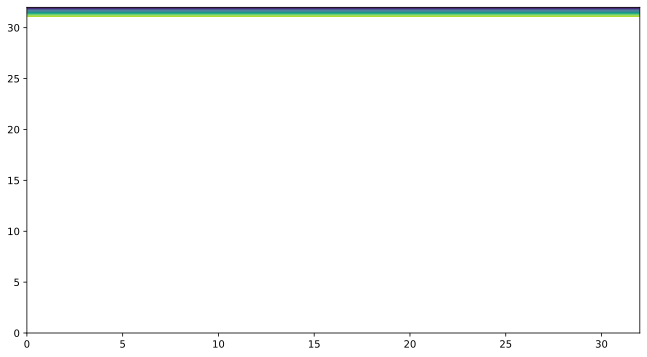

In [89]:
# Plotting initial contour
plt.figure(figsize = (11,6))
plt.contour(omg_sol[0])

In [90]:
start = time.time()
t = 0
while t < tf:
    
    # Solving the Poisson equation
    ω_n = omg_sol[-1].copy()
    itr = 0
    err = 100
    ψ_ks = psi_sol[-1].copy()
    while err > ϵ and itr < max_itr:
        # Storing latest psi for error computation
        ψ_k = ψ_ks.copy()
        
        # Looping over interior points 1 to nx-1 and 1 to nx-2
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                rhs_1 = (((dx*dy)**2)*ω_n[j, i] + (ψ_ks[j, i+1] + ψ_ks[j, i-1])*dy*dy + (ψ_ks[j+1, i]+ψ_ks[j-1, i])*dx*dx)*A
                ψ_ks[j, i] = rhs_1 + (1-β)*ψ_ks[j, i]
        err = np.linalg.norm(ψ_ks - ψ_k)
        itr+=1
    psi_sol.append(ψ_ks)

    # Solving the vorticity transport equation
    ω_n1 = ω_n.copy()
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            conv = ((0.25*dt)/(dx*dy))*((ψ_ks[j, i+1] - ψ_ks[j, i-1])*(ω_n[j+1, i] - ω_n[j-1, i])
            - (ψ_ks[j+1, i] - ψ_ks[j, i-1])*(ω_n[j, i+1] - ω_n[j, i-1]))
            
            diff = ν*dt*((ω_n[j, i+1] + ω_n[j, i-1])/(dx*dx) + (ω_n[j+1, i] + ω_n[j-1, i])/(dy*dy))
            coef = 1 - 2*ν*dt*((1/(dx*dx)) + (1/(dy*dy)))
            ω_n1[j, i] = conv + diff + ω_n[j, i]*coef
    
    # Update boundary conditions of vorticity
    ω_n1[1:-1, 0] = (-2*ψ_ks[1:-1, 1])/(dx*dx) # Left wall 
    ω_n1[1:-1, -1] = (-2*ψ_ks[1:-1, -2])/(dx*dx) # Right wall
    ω_n1[0, 1:-1] = (-2*ψ_ks[1, 1:-1])/(dy*dy) # Bottom wall
    ω_n1[-1, 1:-1] = (-2*ψ_ks[-2, 1:-1])/(dy*dy) - (2*ut)/dy # Top wall
    
    omg_sol.append(ω_n1)
    
    # Computing the velocities
    ψ = psi_sol[-1]
    u = np.zeros([ny, nx])
    v = np.zeros([ny, nx])
    u[-1, :] = ut
    for j in range(1, ny - 1):
        for i in range(1, nx - 1):
            u[j, i] = (ψ[j+1, i] - ψ[j-1, i])/(2*dy)
            v[j, i] = (-1)*(ψ[j, i+1] - ψ[j, i-1])/(2*dx)
    vel_t = np.sqrt(u**2 + v**2)
    vel_sol.append(vel_t)
    u_sol.append(u)
    v_sol.append(v)
    
    time.sleep(dt)
    t+=dt
    progress = t / tf  # Calculate progress as a percentage
    update_progress_bar(int(t/dt), ts)

update_progress_bar(ts, ts)
end = time.time() - start
print(f'\nTime taken for simulation: {round(end, 3)}s')

Time step: [==================================================] 410/410 (100.00%)
Time taken for simulation: 11.242s


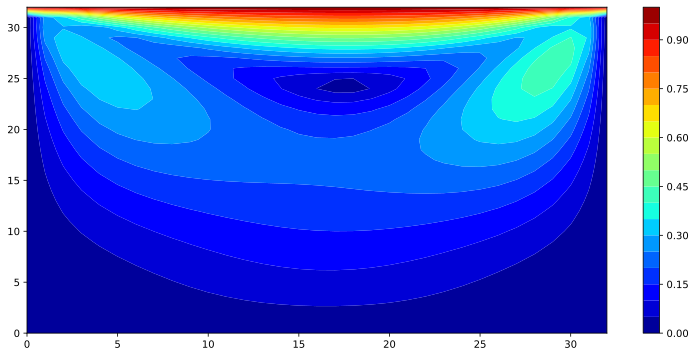

In [91]:
# Final velocity solution
plt.figure(figsize = (13,6))
plt.contourf(vel_sol[-1], cmap = plt.cm.jet, levels=20)
plt.colorbar()
plt.show()

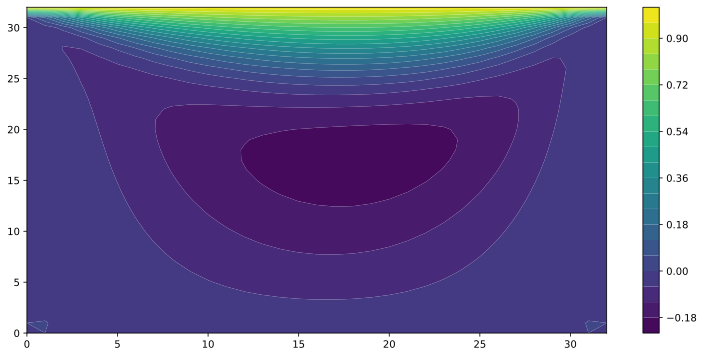

In [92]:
# x-velocity
plt.figure(figsize = (13,6))
plt.contourf(u_sol[-1], levels=20)
plt.colorbar()
plt.show()

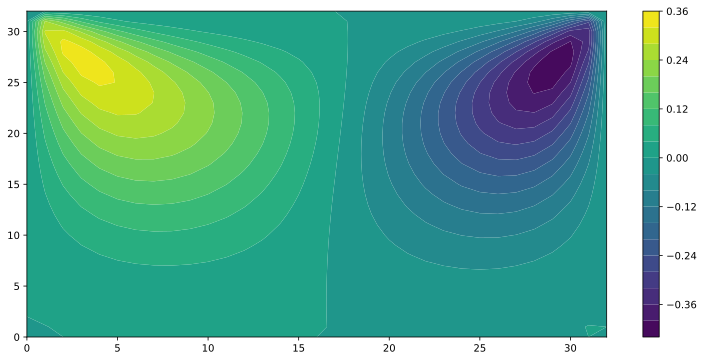

In [93]:
# y-velocity
plt.figure(figsize = (13,6))
plt.contourf(v_sol[-1], levels=20)
plt.colorbar()
plt.show()


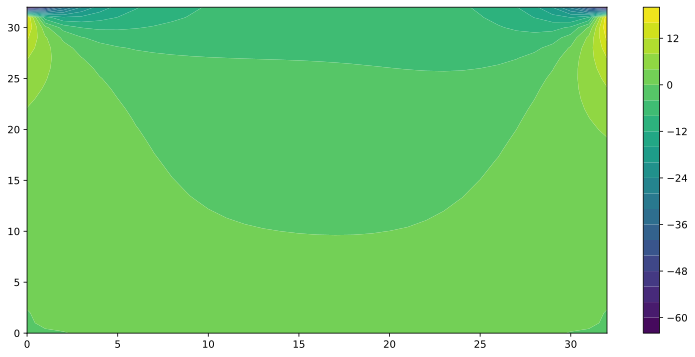

In [94]:
# Vorticity
plt.figure(figsize = (13,6))
plt.contourf(omg_sol[-1], levels=20)
plt.colorbar()
plt.show()

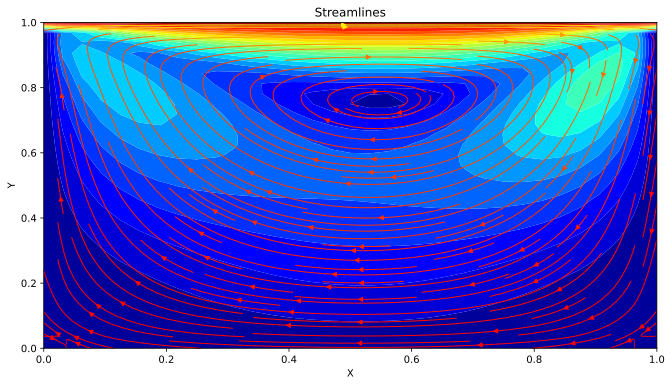

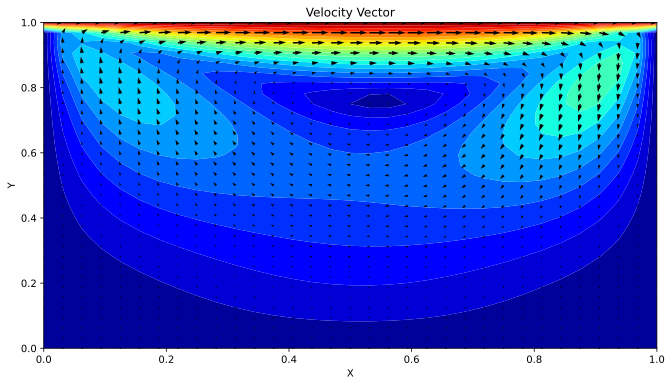

In [95]:
# Streamline
frame = -1
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize = (11, 6))
ax.contourf(X, Y, vel_sol[frame], cmap = plt.cm.jet, levels = 20)
ax.streamplot(X, Y, u_sol[frame], v_sol[frame], color = vel_sol[frame], cmap = plt.cm.autumn, density=1.5, linewidth=1, arrowsize=1)
ax.set(xlabel = 'X', ylabel = 'Y', title = 'Streamlines', xlim = [X[0, 0], X[0, -1]], ylim = [Y[0, 0], Y[-1, 0]])
plt.show()

# Vector
fig, ax = plt.subplots(figsize = (11, 6))
ax.contourf(X, Y, vel_sol[frame], cmap = plt.cm.jet, levels = 20)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html
ax.quiver(X, Y, u_sol[frame], v_sol[frame], scale=30)
ax.set(xlabel = 'X', ylabel = 'Y', title = 'Velocity Vector', xlim = [X[0, 0], X[0, -1]], ylim = [Y[0, 0], Y[-1, 0]])
plt.show()

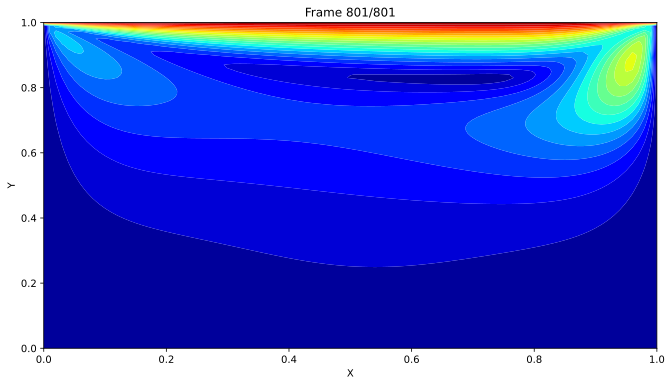

In [83]:
# Vector animation
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize = (11, 6))
def update(frame):
    ax.clear()  # Clear the previous plot
    ax.contourf(X, Y, vel_sol[frame], cmap = plt.cm.jet, levels = 20)
   
    ax.set(xlabel = 'X', ylabel = 'Y', title = f'Frame {frame + 1}/{len(vel_sol)}', xlim = [X[0, 0], X[0, -1]], ylim = [Y[0, 0], Y[-1, 0]])

animation = anm.FuncAnimation(fig, update, frames=list(range(0, len(vel_sol), int(len(vel_sol)/100)))+[len(vel_sol)-1], repeat=False)
animation

In [84]:
animation.save('vector_animation.gif', writer = 'pillow', fps = 10)


In [100]:
#import pandas as pd
#import matplotlib.pyplot as plt

# Read the txt file
#with open('Ghia-1982.txt', 'r') as file:
    #lines = file.readlines()

# Adjust the lines range to match your data
#lines = lines[5:-7]  # Adjust these numbers

# Process lines to obtain data
#data = [list(map(float, line.split())) for line in lines]

# Create DataFrame from data
#df = pd.DataFrame(data, columns=['y', 'Re=100', 'Re=400', 'Re=1000', 'Re=3200', 'Re=5000', 'Re=7500', 'Re=10000'])

# Set y as index
#df.set_index('y', inplace=True)

# Plotting
#plt.figure(figsize=(10,8))
#for column in df.columns:
    #plt.plot(df[column].values, df.index.values, label=column) # use .values to get numpy arrays

#plt.xlabel('u-velocity')
#plt.ylabel('y')
#plt.title('u-velocity for different y and Re')
#plt.legend()
#plt.gca().invert_yaxis()  # To invert y-axis
#plt.grid(True)
#plt.show()

In [101]:
# Plotting
#plt.figure(figsize=(10,8))

#plt.plot(df['Re=100'].values, df.index.values, 'o', label='Re=100-Ghia-1982') # use .values to get numpy arrays
#plt.plot(u[:,int(ny/2)], y, label='Re=100-CFD') # 

#plt.xlabel('u-velocity')
##plt.ylabel('y')
#plt.title('u-velocity for different y and Re')
##plt.legend()
#plt.gca().invert_yaxis()  # To invert y-axis
#plt.grid(True)
#plt.show()